In [1]:
import numpy as np
import os
import random
import pathlib
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import ternausnet.models
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

cudnn.benchmark = True

In [2]:
working_path            = pathlib.Path().resolve()
path_object             = pathlib.Path(working_path)
parent_path             = path_object.parent
images_directory = os.path.join(parent_path, "data/raw/training/images")
masks_directory = os.path.join(parent_path, "data/raw/training/groundtruth")

In [3]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:120]
val_images_filenames = correct_images_filenames[-24:]

print(len(train_images_filenames), len(val_images_filenames))

120 24


In [4]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    maksk = np.array([np.max(row) for row in mask])
    mask[mask == 255.0] = 1.0
    mask[mask == 0.0]= 0.0
    return mask

In [5]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        image = image/255.0
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

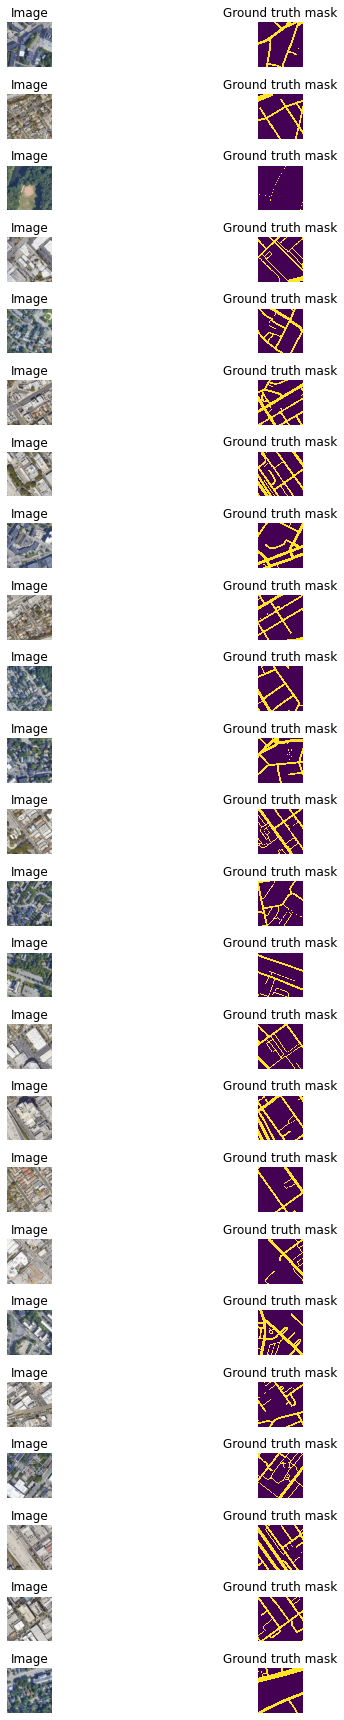

In [6]:
display_image_grid(val_images_filenames, images_directory, masks_directory)

In [7]:
class RoadDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [8]:
img_size=128
train_transform = A.Compose(
    [
        A.Resize(img_size, img_size),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = RoadDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(img_size, img_size), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = RoadDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

In [9]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

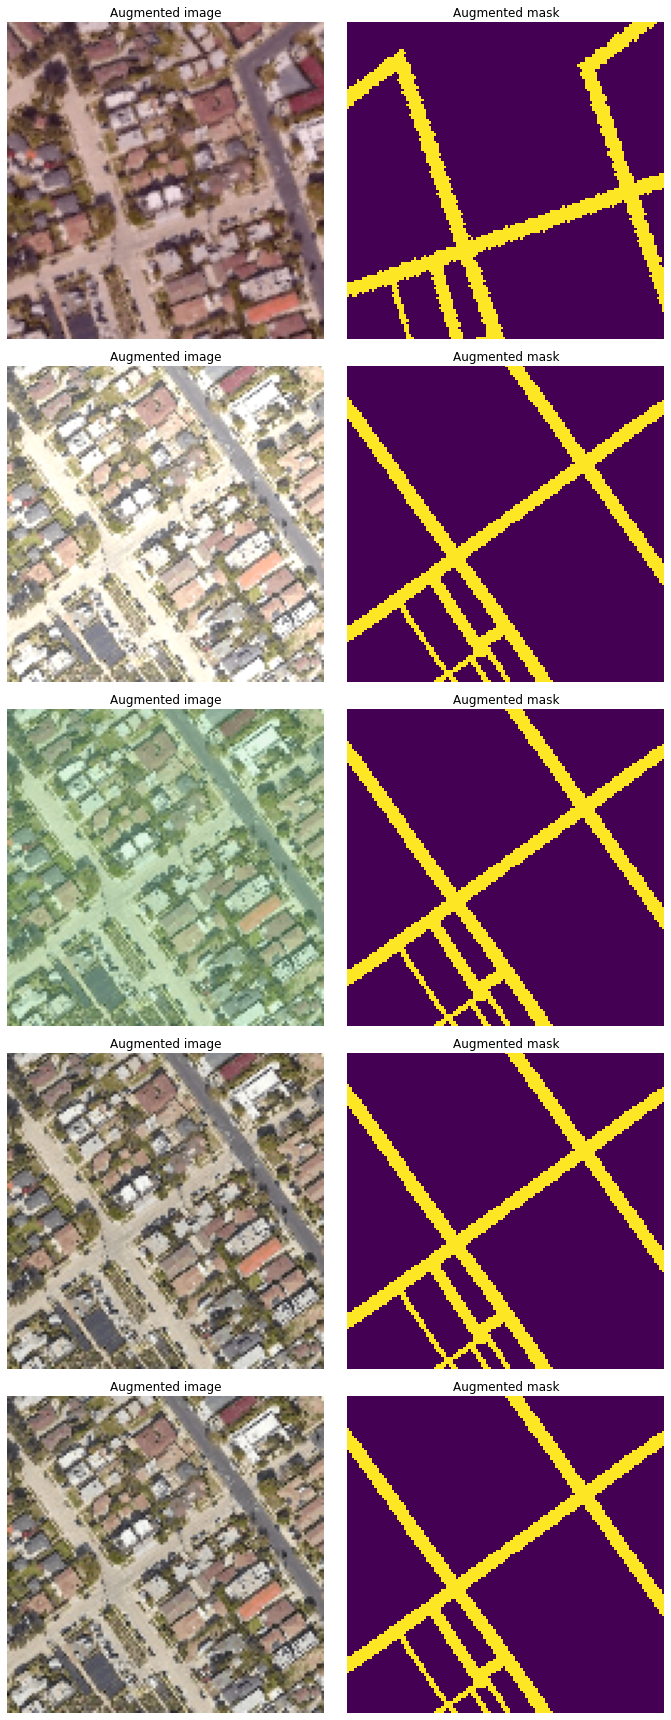

In [10]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

In [11]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [12]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [13]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [14]:
def create_model(params):
    model = getattr(ternausnet.models, params["model"])(pretrained=True)
    model = model.to(params["device"])
    return model

In [15]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

In [16]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

In [17]:
params = {
    "model": "UNet16",
    "device": "cuda",
    "lr": 0.0005,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 30,
}

In [18]:
model = create_model(params)
model = train_and_validate(model, train_dataset, val_dataset, params)

Epoch: 30. Validation. Loss: 0.315: 100%|████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.06it/s]


In [19]:
class RoadDatasetInference(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [20]:
test_transform = A.Compose(
    [A.Resize(img_size, img_size), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = RoadDatasetInference(val_images_filenames, images_directory, transform=test_transform,)

In [21]:
predictions = predict(model, params, test_dataset, batch_size=16)

In [22]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)

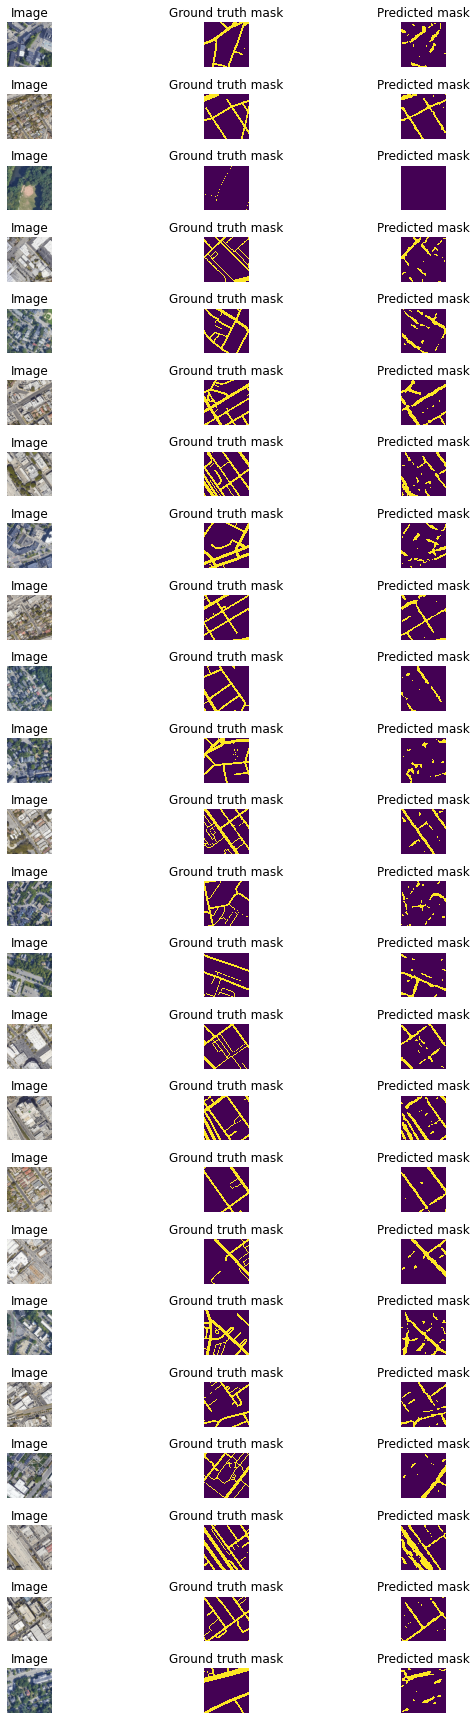

In [23]:
display_image_grid(val_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)
